# Bibliotecas

In [ ]:
!pip install -U scikit-learn
!pip install pickle5

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Dados

In [ ]:
treino = pd.read_excel('/content/drive/MyDrive/Mestrado/Resultados.xlsx', sheet_name = 'Dados_Treino')
teste = pd.read_excel('/content/drive/MyDrive/Mestrado/Resultados.xlsx', sheet_name = 'Dados_Teste')

In [ ]:
treino_per_g = np.log10(treino['Permeabilidade Gas']*1000)
testes_per_g = np.log10(teste['Permeabilidade Gas']*1000)
treino_per_sdr = np.log10(treino['SDR']*1000)
testes_per_sdr = np.log10(teste['SDR']*1000)
treino_per_han = np.log10(treino['Han']*1000)
testes_per_han = np.log10(teste['Han']*1000)
treino_per_rf = np.log10(treino['Random Forest']*1000)
testes_per_rf = np.log10(teste['Random Forest']*1000)
treino_per_mlp = np.log10(treino['Multi Layer Perceptron']*1000)
testes_per_mlp = np.log10(teste['Multi Layer Perceptron']*1000)
treino_per_gb = np.log10(treino['Gradient Boosting']*1000)
testes_per_gb = np.log10(teste['Gradient Boosting']*1000)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
modelos = ['Gás', 'SDR', 'Han', 'Random Forest', 'Gradient Boosting', 'MLP']
avg_treino = [np.average(treino_per_g), np.average(treino_per_sdr), np.average(treino_per_han),
              np.average(treino_per_rf), np.average(treino_per_gb), np.average(treino_per_mlp)]
avg_teste = [np.average(testes_per_g), np.average(testes_per_sdr), np.average(testes_per_han),
             np.average(testes_per_rf), np.average(testes_per_gb), np.average(testes_per_mlp)]
var_treino = [np.var(treino_per_g), np.var(treino_per_sdr), np.var(treino_per_han),
              np.var(treino_per_rf), np.var(treino_per_gb), np.var(treino_per_mlp)]
var_teste = [np.var(testes_per_g), np.var(testes_per_sdr), np.var(testes_per_han),
             np.var(testes_per_rf), np.var(testes_per_gb), np.var(testes_per_mlp)]
std_treino = [np.std(treino_per_g), np.std(treino_per_sdr), np.std(treino_per_han),
              np.std(treino_per_rf), np.std(treino_per_gb), np.std(treino_per_mlp)]
std_teste = [np.std(testes_per_g), np.std(testes_per_sdr), np.std(testes_per_han),
             np.std(testes_per_rf), np.std(testes_per_gb), np.std(testes_per_mlp)]

estatistica = pd.DataFrame({'Modelos': modelos,
                            'Média Treino': avg_treino,
                            'Média Teste': avg_teste,
                            'Variância Treino': var_treino,
                            'Variância Teste': var_teste,
                            'Desvio Padrão Treino': std_treino,
                            'Desvio Padrão Teste': std_teste})
estatistica.to_excel('/content/sample_data/Estatistica.xlsx')

## Funções

In [ ]:
def VisualizarPredicoes (Dados, modelo_previsao, Pasta_Salvamento = None, Data= None, Modelo = None,
                          Litofacies = None, Salvar = False, Sigma = False, Valor_Sigma = 3.64):
    eixo_x = 'Gas Permeability (mD)'
    eixo_y = 'NMR Permeability (mD)'
    reta = pd.DataFrame({'x' : np.arange(1000),
                         'y' : np.arange(1000)})
    sns.scatterplot(data = Dados,
                    x = 'Permeabilidade Gas',
                    y = str(modelo_previsao),
                    hue = Litofacies,
                    palette = 'Set1')
    sns.lineplot(data = reta,
                 x = 'x',
                 y = 'y')

    if Sigma == True:
        plt.plot(reta['x'], reta['y'] * Valor_Sigma, "b-.", linewidth=1)
        plt.plot(reta['x'], reta['y'] / Valor_Sigma, "b-.", linewidth=1, label = f'+/- \u03C3: {Valor_Sigma:.2f}')

    plt.xlabel(eixo_x)
    plt.ylabel(eixo_y)
    plt.xlim(0.0001,1000)
    plt.ylim(0.0001,1000)
    plt.legend(loc="upper left", fontsize=10)

    plt.xscale('log')
    plt.yscale('log')

    if Salvar == True:
        plt.savefig(Pasta_Salvamento + Data + titulo + '.png', format='png')

def erro_sigma(previsao, gas):
    N = len(previsao)
    k_p = np.log10(previsao)
    k_g = np.log10(gas)
    N = len(k_p)
    soma = np.sum((k_p-k_g)**2)
    raiz = np.sqrt(soma/N)
    sigma = 10**(raiz)
    return sigma


def VisualizarPorosidade(Dados, Pasta_Salvamento = None, Modelo = None,
                          Litofacies = None, Salvar = False, Erro = False):
    titulo = f'Gas porosity adjustment with NMR\n to the {Modelo}'                                        # Nomes do Gráfico
    eixo_x = 'Gas Porosity (%)'
    eixo_y = 'NMR Porosity (%)'
    legenda = ['Expected outcome', 'NMR Porosity']


    reta = pd.DataFrame({'x' : np.arange(40),                                             # Determinando Reta de ajuste
                         'y' : np.arange(40)})

    sns.scatterplot(x = Dados['Porosidade Gas']*100,
                    y = Dados['Porosidade RMN']*100,
                    hue = Dados['Litofacies'],
                    palette = 'Set1')

    sns.lineplot(data = reta,
                x = 'x',
                y = 'y')

    if Erro == True:
      valor_erro = mean_squared_error(Dados['Porosidade Gas']*100, Dados['Porosidade RMN']*100)
      plt.plot(reta['x'], reta['y'] + valor_erro, "b-.", linewidth=1)
      plt.plot(reta['x'], reta['y'] - valor_erro, "b-.", linewidth=1, label = f'+/- \u03B5: {valor_erro:.2f}')
      plt.legend(loc="upper left", fontsize=10)

    plt.xlabel(eixo_x)                                                                 # Determinando os nomes
    plt.ylabel(eixo_y)
    plt.xlim(0, 35)
    plt.ylim(0, 35)




    if Salvar == True:
        plt.savefig(Pasta_Salvamento + titulo + '.png', format='png')


def VisualizarPoroPer(Dados, Modelo, Pasta_Salvamento = None):
    eixo_x = 'Porosity (%)'
    eixo_y = 'Permeability (md)'

    sns.scatterplot(x = Dados['Porosidade Gas']*100,
                    y = Modelo,
                    hue = Dados['Litofacies'],
                    palette = 'Set1')


    plt.xlabel(eixo_x)                                                                 # Determinando os nomes
    plt.ylabel(eixo_y)
    plt.xlim(0, 35.0)
    plt.ylim(0.0001,5000.0)
    plt.yscale('log')

def Histogram(Dados, permeabilidade):
  sns.histplot(data = Dados, x = permeabilidade, kde=True, bins = 32,
               hue = 'Litofacies', multiple="stack", stat="percent",
               log_scale=True, palette = 'Set1')
  plt.ylabel('Percentage (%)')
  plt.xlabel('Permeability (mD)')
  plt.xlim(0.001, 1000)

# Visualizações

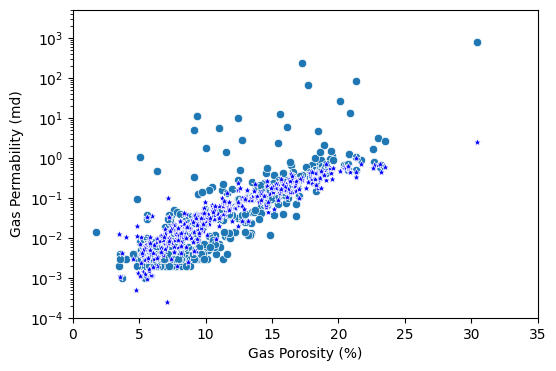

In [ ]:
titulo = 'Adjusting Porosity with Permeability\n Training Data and SDR model'                                        # Nomes do Gráfico
eixo_x = 'Gas Porosity (%)'
eixo_y = 'Gas Permability (md)'

fig, ax = plt.subplots(figsize = (6,4))                                              # Criando os subplots

sns.scatterplot(x = treino['Porosidade Gas']*100,
                y = treino['Permeabilidade Gas'])

sns.scatterplot(x = treino['Porosidade Gas']*100,
                y = treino['SDR'],
                marker = '*',
                color = 'b')


ax.set_xlabel(eixo_x)                                                                 # Determinando os nomes
ax.set_ylabel(eixo_y)
ax.set(xlim=(0, 35),
           ylim=(0.0001,5000.0))
plt.yscale('log')

plt.show()

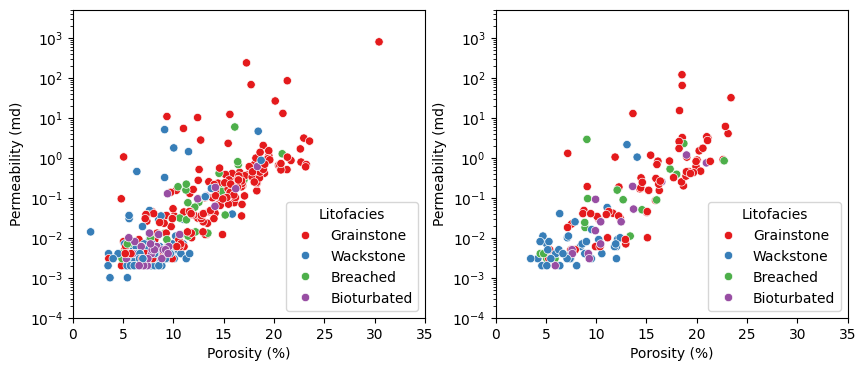

In [ ]:
fig = plt.figure(figsize = (10,4))
ax1 = fig.add_subplot(121)
VisualizarPoroPer(treino, treino['Permeabilidade Gas'])
ax2 = fig.add_subplot(122)
VisualizarPoroPer(teste, teste['Permeabilidade Gas'])

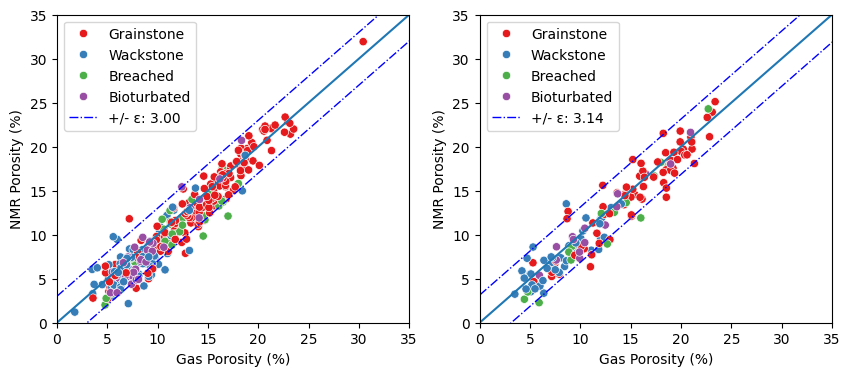

In [ ]:
fig = plt.figure(figsize = (10,4))
ax1 = fig.add_subplot(121)
VisualizarPorosidade(treino, Erro = True, Modelo = 'Training')
ax2 = fig.add_subplot(122)
VisualizarPorosidade(teste, Erro=True, Modelo = 'Test')

In [ ]:
erro_SDR_treino = erro_sigma(treino['SDR'], treino['Permeabilidade Gas'])
erro_SDR_teste = erro_sigma(teste['SDR'], teste['Permeabilidade Gas'])
erro_Han_treino = erro_sigma(treino['Han'], treino['Permeabilidade Gas'])
erro_Han_teste = erro_sigma(teste['Han'], teste['Permeabilidade Gas'])

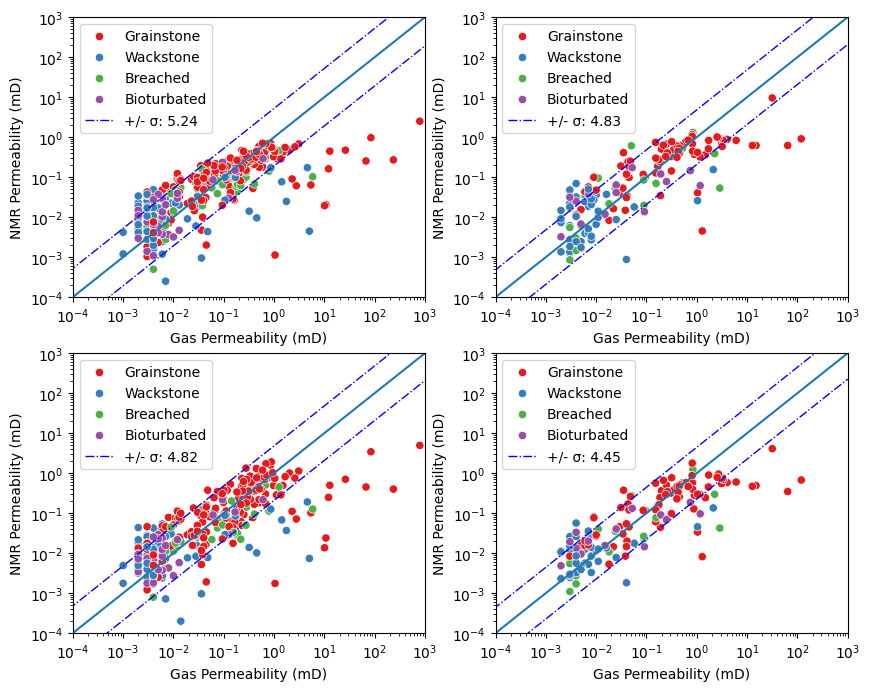

In [ ]:
fig = plt.figure(figsize = (10,8))
ax1 = fig.add_subplot(221)
VisualizarPredicoes(Dados = treino, modelo_previsao = 'SDR', Sigma = True,
                    Valor_Sigma = erro_SDR_treino, Litofacies = 'Litofacies', Modelo = 'Train SDR')
ax2 = fig.add_subplot(222)
VisualizarPredicoes(Dados = teste, modelo_previsao = 'SDR', Sigma = True,
                    Valor_Sigma = erro_SDR_teste, Litofacies = 'Litofacies', Modelo = 'Test SDR')
ax3 = fig.add_subplot(223)
VisualizarPredicoes(Dados = treino, modelo_previsao = 'Han', Sigma = True,
                    Valor_Sigma = erro_Han_treino, Litofacies = 'Litofacies', Modelo = 'Training Han')
ax4 = fig.add_subplot(224)
VisualizarPredicoes(Dados = teste, modelo_previsao = 'Han', Sigma = True,
                    Valor_Sigma = erro_Han_teste, Litofacies = 'Litofacies', Modelo = 'Test Han')

plt.savefig('/content/sample_data/perm-analitico.png', format='png')

In [ ]:
erro_RFR_treino = erro_sigma(treino['Random Forest'], treino['Permeabilidade Gas'])
erro_RFR_teste = erro_sigma(teste['Random Forest'], teste['Permeabilidade Gas'])
erro_GBR_treino = erro_sigma(treino['Gradient Boosting'], treino['Permeabilidade Gas'])
erro_GBR_teste = erro_sigma(teste['Gradient Boosting'], teste['Permeabilidade Gas'])
erro_MLP_treino = erro_sigma(treino['Multi Layer Perceptron'], treino['Permeabilidade Gas'])
erro_MLP_teste = erro_sigma(teste['Multi Layer Perceptron'], teste['Permeabilidade Gas'])

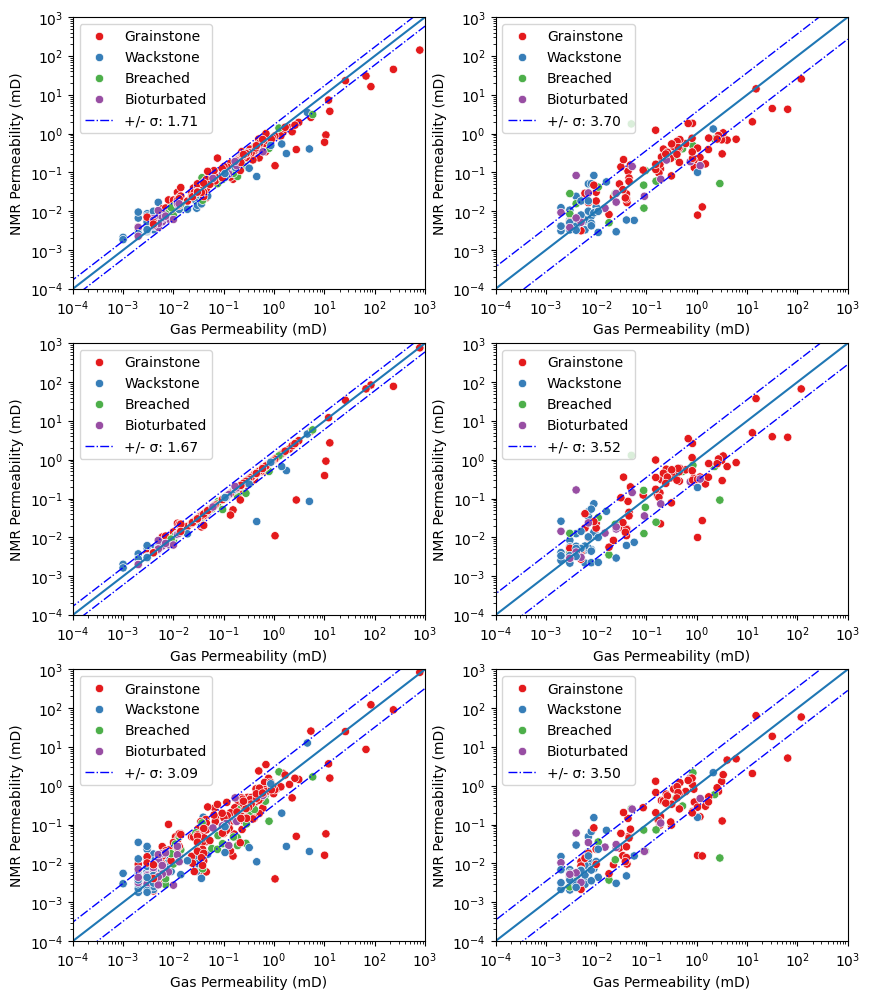

In [ ]:
fig = plt.figure(figsize = (10,12))
ax1 = fig.add_subplot(321)
VisualizarPredicoes(Dados = treino, modelo_previsao = 'Random Forest', Sigma = True,
                    Valor_Sigma = erro_RFR_treino, Litofacies = 'Litofacies', Modelo = 'Treaining Random Forest')
ax2 = fig.add_subplot(322)
VisualizarPredicoes(Dados = teste, modelo_previsao = 'Random Forest', Sigma = True,
                    Valor_Sigma = erro_RFR_teste, Litofacies = 'Litofacies', Modelo = 'Test Random Forest')
ax3 = fig.add_subplot(323)
VisualizarPredicoes(Dados = treino, modelo_previsao = 'Gradient Boosting', Sigma = True,
                    Valor_Sigma = erro_GBR_treino, Litofacies = 'Litofacies', Modelo = 'Gradient Boosting')
ax4 = fig.add_subplot(324)
VisualizarPredicoes(Dados = teste, modelo_previsao = 'Gradient Boosting', Sigma = True,
                    Valor_Sigma = erro_GBR_teste, Litofacies = 'Litofacies', Modelo = 'Gradient Boosting')
ax4 = fig.add_subplot(325)
VisualizarPredicoes(Dados = treino, modelo_previsao = 'Multi Layer Perceptron', Sigma = True,
                    Valor_Sigma = erro_MLP_treino, Litofacies = 'Litofacies', Modelo = 'Treino Multi Layer Perceptron')
ax4 = fig.add_subplot(326)
VisualizarPredicoes(Dados = teste, modelo_previsao = 'Multi Layer Perceptron', Sigma = True,
                    Valor_Sigma = erro_MLP_teste, Litofacies = 'Litofacies', Modelo = 'Teste Multi Layer Perceptron')
plt.savefig('/content/sample_data/perm-ia.png', format='png')

# Hiperparâmetros

In [ ]:
treinamento = '/content/drive/MyDrive/Mestrado/Artigo - 1/Random Forest/Versão_2.0_Random_Forest_Regressor.sav'
programa_MLP = pickle.load(open(treinamento, 'rb'))
print(programa_MLP.get_params)
print(pd.DataFrame(programa_MLP.cv_results_)['mean_fit_time'].sum())

<bound method BaseEstimator.get_params of GridSearchCV(estimator=RandomForestRegressor(random_state=0), n_jobs=64,
             param_grid={'bootstrap': [True], 'ccp_alpha': [0.0],
                         'criterion': ['squared_error'], 'max_depth': [None],
                         'max_features': [1.0], 'max_leaf_nodes': [None],
                         'max_samples': [None], 'min_impurity_decrease': [0.0],
                         'min_samples_leaf': [1], 'min_samples_split': [2],
                         'min_weight_fraction_leaf': [0.0],
                         'n_estimators': [100], 'oob_score': [False]},
             return_train_score=True)>
1.0994946002960204


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.3.0 when using version 1.3.2. This might lead to break

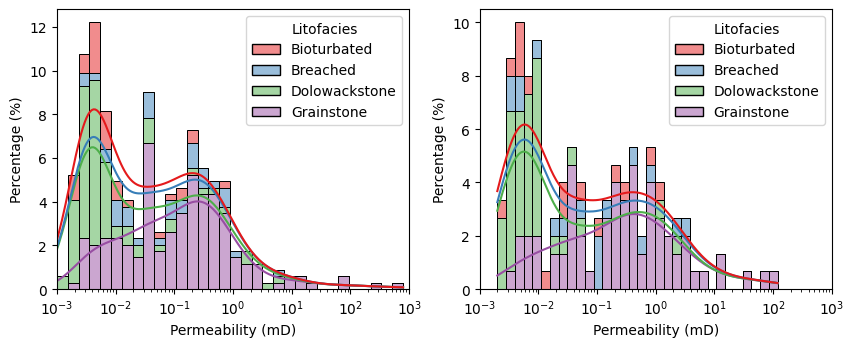

In [ ]:
fig = plt.figure(figsize = (10,8))
ax1 = fig.add_subplot(221)
Histogram(treino, 'Permeabilidade Gas')
ax2 = fig.add_subplot(222)
Histogram(teste, 'Permeabilidade Gas')

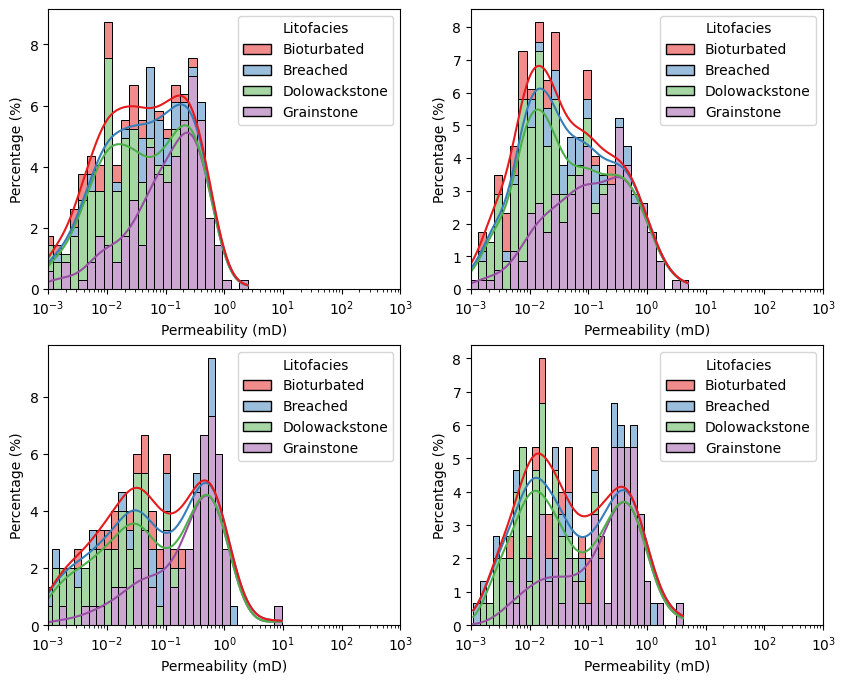

In [ ]:
fig = plt.figure(figsize = (10,8))
ax1 = fig.add_subplot(221)
Histogram(treino, 'SDR')
ax1 = fig.add_subplot(223)
Histogram(teste, 'SDR')
ax1 = fig.add_subplot(222)
Histogram(treino, 'Han')
ax1 = fig.add_subplot(224)
Histogram(teste, 'Han')

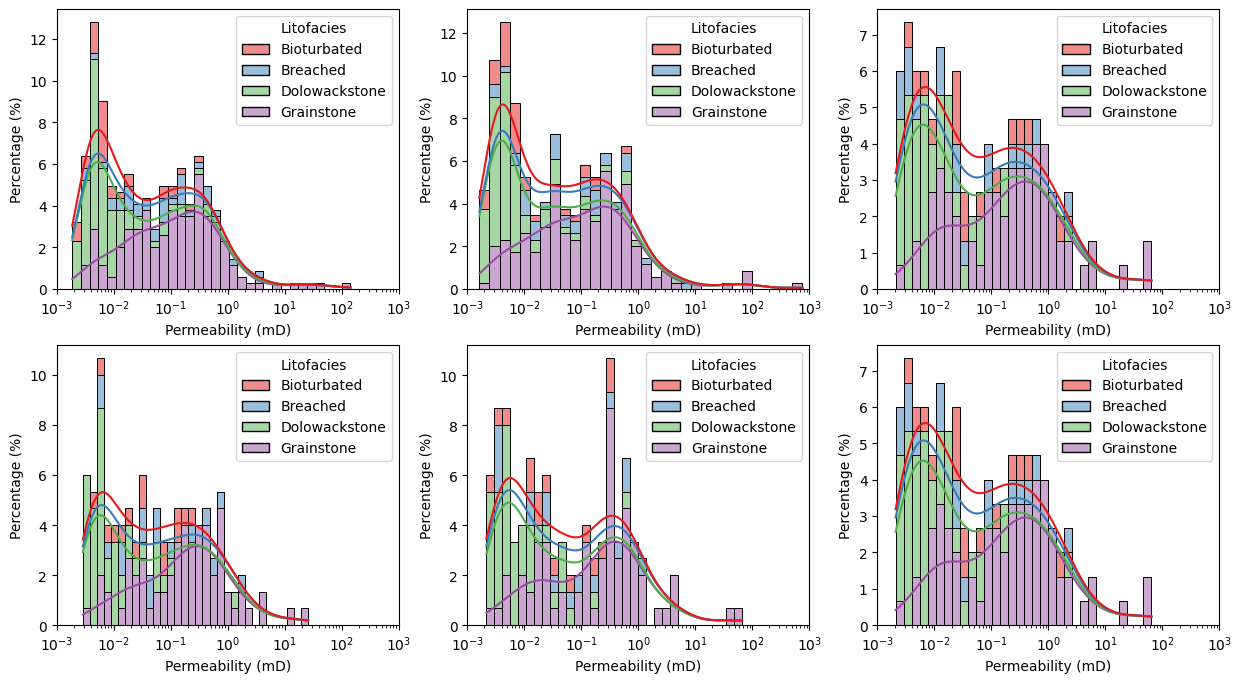

In [ ]:
fig = plt.figure(figsize = (15,8))
ax1 = fig.add_subplot(231)
Histogram(treino, 'Random Forest')
ax2 = fig.add_subplot(234)
Histogram(teste, 'Random Forest')
ax3 = fig.add_subplot(232)
Histogram(treino, 'Gradient Boosting 1.3')
ax4 = fig.add_subplot(235)
Histogram(teste, 'Gradient Boosting 1.3')
ax5 = fig.add_subplot(233)
Histogram(teste, 'Multi Layer Perceptron')
ax6 = fig.add_subplot(236)
Histogram(teste, 'Multi Layer Perceptron')


In [ ]:
horas = [108.9272222, 462.7280556, 108.1327778]
combinações = [12180, 47880, 2348]
modelos = ['Random Forest Regressor', 'Gradient Boosting Regressor', 'Multi Layer Perceptron']

df = pd.DataFrame({'Modelo': modelos,
                   'Combinações Hiperparâmetros': combinações,
                   'Horas de Treino': horas})
df

,Modelo,Combinações Hiperparâmetros,Horas de Treino
0,Random Forest Regressor,12180,108.927222
1,Gradient Boosting Regressor,47880,462.728056
2,Multi Layer Perceptron,2348,108.132778


Text(0.5, 0, 'Horas de Treinamento')

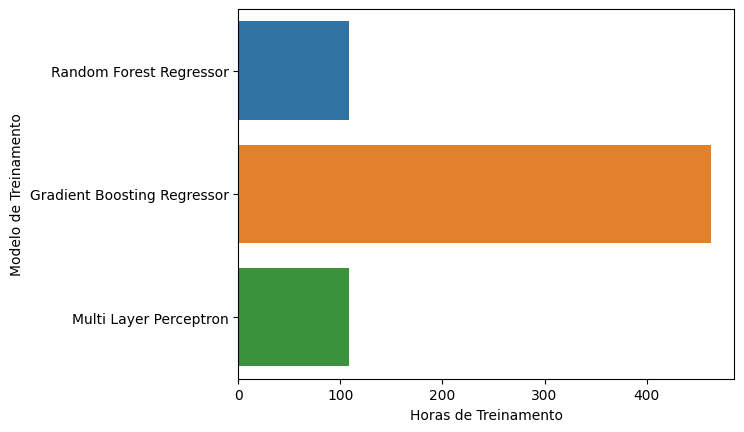

In [ ]:
sns.barplot(data = df, y = 'Modelo', x = 'Horas de Treino')
plt.ylabel('Modelo de Treinamento')
plt.xlabel('Horas de Treinamento')

Text(0.5, 0, 'Permeabilidade (mD)')

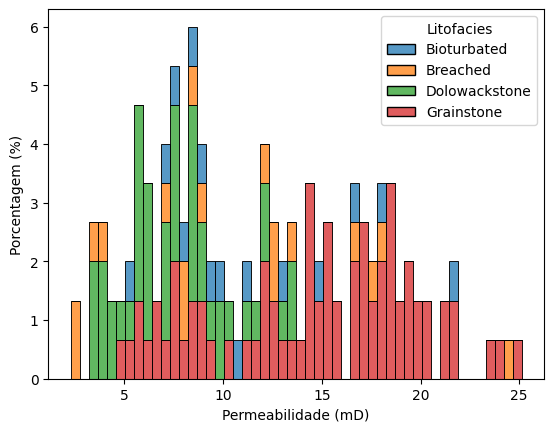

In [ ]:
sns.histplot(data = teste, x = teste['Porosidade RMN']*100, bins = 50, hue = 'Litofacies', multiple="stack", stat="percent")
plt.ylabel('Porcentagem (%)')
plt.xlabel('Permeabilidade (mD)')